### Part A
#### 1.

The PDF of stress factor x is given by:

$$ p(x|\theta) = \frac{1}{\pi}\frac{1}{1 + (x - \theta)^2} \quad, $$

where theta is an unknown constant. We assume that the samples $ D_j , j = 1, 2 $ are Independent Identically Distributed
(i.i.d.) i.e.  they have been drawn independently from the same distribution $ p(x|\theta_j, \omega_j) $. Thus, the 
common PDF from the samples is:

$$ p(D_j | \theta_j) = \prod_{i=1}^{N_j} p(x_i | \theta_j), \quad j = 1, 2 \quad. $$

We will use the Maximum Likelihood (ML) Method to estimate the parameters $\hat{\theta}_1, \hat{\theta}_2$. Therefore, 
we want to maximize the log-likelihood function:

$$ L(D_j | \theta_j) = \sum_{i=1}^{N_j} lnp(x_i | \theta_j), \quad j = 1, 2 \quad, $$

with respect to $ \theta_j $.

#### 2.

Consider the Bayes Decision Rule:

$$ P(\omega_1 | x) > P(\omega_2 | x) $$

or

$$ \frac{p(x|\omega_1) P(\omega_1)}{p(x)} > \frac{p(x|\omega_2) P(\omega_2)}{p(x)} $$

or

$$ logp(x|\omega_1) + logP(\omega_1) > logp(x|\omega_2) + logP(\omega_2), $$

where the class conditional densities $p(x|\omega_1), p(x|\omega_2)$ have already been computed using ML estimation. 
By selecting as discriminant function the:

$$ g(x) = logp(x|\omega_1) - logp(x|\omega_2) + logP(\omega_1) - logP(\omega_2) \quad, $$

we classify the element with feature $x$ to class $\omega_1$ if $h(x) > 0$ and to $\omega_2$ otherwise.


theta1 (no stress): 2.599795604752384
theta2 (intense stress): -3.1585766804948574


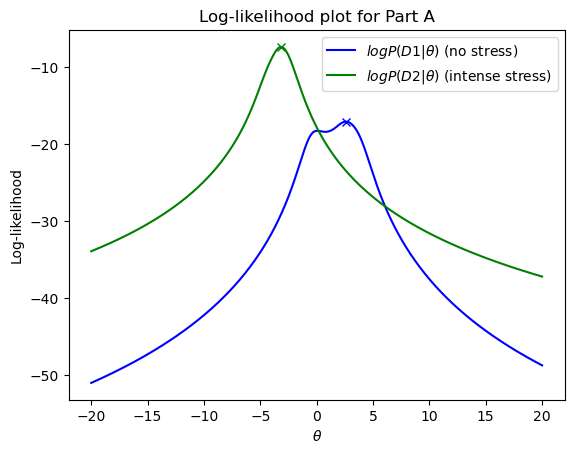

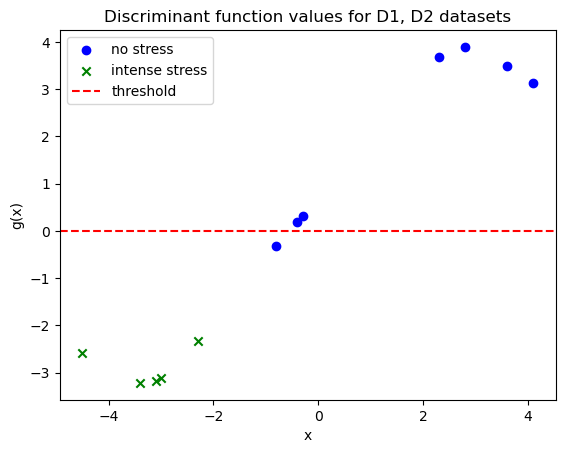

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

D1 = np.array([2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1])  # No stress data
D2 = np.array([-4.5, -3.4, -3.1, -3.0, -2.3])  # Intense stress data

class ClassifierA:

    @staticmethod
    def p_x_theta(theta, x):
        """
        Computes the probability density function (PDF) for a given theta and data x.
        
        Args:
            theta (float): The parameter of the distribution (location).
            x (array-like): The input data (can be a numpy array or list).
        
        Returns:
            numpy.ndarray: The probability density for each element in x.
        
        """
        # Ensure x is treated as a numpy array, for element-wise operations
        x = np.asarray(x)  # Converts x to a numpy array if it's not already
        return 1 / (1 + (x - theta) ** 2) / np.pi

    @staticmethod
    def logp(theta, D):
        """
        Computes the log-likelihood for the data D given a parameter theta.
        
        Args:
            theta (float): The parameter of the distribution (location).
            D (array-like): The dataset for which the log-likelihood is computed.
        
        Returns:
            float: The log-likelihood of the data D given theta.
        
        """
        return np.sum(np.log(ClassifierA.p_x_theta(theta, D)))  # Sum of log probabilities

    @staticmethod
    def fit(D, theta_canditates):
        """
        Fits the model to the data D by finding the value of theta that maximizes
        the log-likelihood function (i.e., minimizing the negative log-likelihood).
        
        Args:
            D (array-like): The dataset to fit the model to.
            theta_candidates (array-like): A list of initial theta values to search.
        
        Returns:
            float: The optimal theta value that maximizes the log-likelihood for the data D.
        
        """
        fun_values = np.zeros(len(theta_canditates))  # Array to store function values
        theta_values = np.zeros(len(theta_canditates))  # Array to store corresponding theta values

        # Loop over candidate thetas, and minimize the negative log-likelihood
        for i, x0 in enumerate(theta_canditates):
            # Maximize log-likelihood by minimizing the negation of it using a lambda function
            result = minimize(lambda theta: -ClassifierA.logp(theta, D), x0, method='BFGS')
            theta_values[i] = result.x[0]  # Best theta value for the specific starting point
            fun_values[i] = result.fun  # Negative log-likelihood corresponding to the best theta

        idx = np.argmin(fun_values)  # Find the index with the minimum function value
        return theta_values[idx]  # Return the optimal theta
    
    @staticmethod
    def predict(D, p1, p2, theta1, theta2):
        """
        Predicts the class of each data point based on the discriminant function.
        The function computes the log-likelihood ratio between two classes (D1 and D2),
        weighted by their a-priori probabilities p1 and p2.
        
        Args:
            D (array-like): A dataset containing the feature values for which predictions 
                are to be made. This can be a numpy array or list.
            p1 (float): The a-priori probability of class 1 (no stress).
            p2 (float): The a-priori probability of class 2 (intense stress).
            theta1 (float): The optimal value of the parameter theta for class 1 (no stress)
            theta2 (float): The optimal value of the parameter theta for class 2 (intense stress)
        
        Returns:
            numpy.ndarray: The predicted discriminant function values for each data point in D1 and D2.
        
        """
        # Calculate and return discriminant function for each point in D
        return np.log(ClassifierA.p_x_theta(D, theta1)) - np.log(ClassifierA.p_x_theta(D, theta2)) + np.log(p1) - np.log(p2)


clf = ClassifierA()  # Create an instance of Classifier
# Candidate thetas for D1, on the interval where the optimal theta lies, as observed from the plot
theta_candidates = np.linspace(-5., 5., 10)
theta1 = clf.fit(D1, theta_candidates)
# Candidate thetas for D2, on the interval where the optimal theta lies, as observed from the plot
theta_candidates = np.linspace(-5., 0., 10)
theta2 = clf.fit(D2, theta_candidates)
print(f'theta1 (no stress): {theta1}')
print(f'theta2 (intense stress): {theta2}')

# Compute log-likelihood values for both classes
x = np.linspace(-20, 20, 1000)  # Range for theta values
y1 = np.array([clf.logp(theta, D1) for theta in x])  # Log-likelihood for D1
y2 = np.array([clf.logp(theta, D2) for theta in x])  # Log-likelihood for D2

# Plot the log-likelihood curves for both datasets
plt.plot(x, y1, label=r'$logP(D1|\theta)$ (no stress)', color='blue')
plt.plot(x, y2, label=r'$logP(D2|\theta)$ (intense stress)', color='green')

# Mark the optimal theta values on the plot
plt.plot(theta1, clf.logp(theta1, D1), color='blue', marker='x')
plt.plot(theta2, clf.logp(theta2, D2), color='green', marker='x')

# Labeling the plot
plt.xlabel(r'$\theta$')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood plot for Part A')
plt.legend()
plt.show()

# Calculate a-priori probabilities for each class
N1 = len(D1)
N2 = len(D2)
p1 = N1 / (N1 + N2)
p2 = N2 / (N1 + N2)

# Get the discriminant values for the two classes
predictions1 = clf.predict(D1, p1, p2, theta1, theta2)
predictions2 = clf.predict(D2, p1, p2, theta1, theta2)

# Scatter plot of the data points and the discriminant function values
plt.scatter(D1, predictions1, label='no stress', color='blue', marker='o')
plt.scatter(D2, predictions2, label='intense stress', color='green', marker='x')

# Add a horizontal dashed line (threshold for classification)
plt.axhline(y=0.0, color='red', linestyle='--', label="threshold")

# Labeling the plot
plt.xlabel('x')
plt.ylabel('g(x)')
plt.title('Discriminant function values for D1, D2 datasets')
plt.legend()
plt.show()

### Part B

In [ ]:
class ClassifierB:

    @staticmethod
    def p_x_theta(theta, x):
        """
        Computes the probability density function (PDF) for a given theta and data x.
        
        Args:
            theta (float): The parameter of the distribution (location).
            x (array-like): The input data (can be a numpy array or list).
        
        Returns:
            numpy.ndarray: The probability density for each element in x.
        
        """
        # Ensure x is treated as a numpy array, for element-wise operations
        x = np.asarray(x)  # Converts x to a numpy array if it's not already
        return 1 / (1 + (x - theta) ** 2) / np.pi

    @staticmethod
    def p_theta(theta):
        theta = np.asarray(theta)
        return 1 / (1 + (theta / 10) ** 2) / (10 * np.pi)

    @staticmethod
    def p_D_theta(theta, D):
        theta = np.asarray(theta)
        return np.array([np.prod(ClassifierB.p_x_theta(t, D)) for t in theta])
    
    @staticmethod
    def p_theta_D(theta, D):
        x = np.linspace(-1000, 1000, 1000)
        y = ClassifierB.p_D_theta(x, D) * ClassifierB.p_theta(x)
        return ClassifierB.p_D_theta(theta, D) * ClassifierB.p_theta(theta) / np.trapz(y, x)


    clf = ClassifierB()
    x = np.linspace(-1000, 1000, 1000)
    y = clf.p_theta(x)
    y1 = clf.p_theta_D(x, D1)
    # y2 = clf.p_theta_D(x, D2)
    print(y)

TypeError: iteration over a 0-d array

In [38]:
def foo(x):
    return x

arr2 = np.array([1, 2, 3, 4])
arr = np.array([foo(i) for i in arr2])

for x in arr:
    print(x)

1
2
3
4
